In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
## Install older opencv package for using sift features
!pip install opencv-python==3.4.10.37
!pip install opencv-contrib-python==3.4.10.37

In [41]:
import cv2
import numpy as np
import os
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [42]:
# Get the training classes names and store in a list
# use the folder names as class labels

train_path='/content/drive/MyDrive/CV/Notebooks/Practice/datasets/BelgiumTS/Training'
training_names=os.listdir(train_path)
training_names.sort()

In [43]:
training_names

['00001',
 '000010',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009']

In [44]:
# Get path to all the images and save it in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

# function to list all file names in directory
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

# fill placeholder empty list with image path, classes and add class ID number
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1 # for creating class id instead of using 00001, 00002 etc

In [45]:
# Create feature extraction and keypoint detector objects
    #Use SIFT
# Create List where all the descriptors will be stored
des_list = []

sift = cv2.xfeatures2d.SIFT_create()

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = sift.detectAndCompute(im, None)
    des_list.append((image_path, des))   
    
# Stack all of the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))  

In [48]:
#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)  

# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 200  #k value chosen tentatively
voc, variance = kmeans(descriptors_float, k, 1) 

In [49]:
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [50]:
# Scaling the words
#Standardize features by removing the mean and scaling to unit variance
#In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [51]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the Linear SVM
from sklearn.svm import LinearSVC
clf = LinearSVC(max_iter=10000)  #Default okf 100 is not converging
clf.fit(im_features, np.array(image_classes))

LinearSVC(max_iter=10000)

In [52]:
# Save the SVM
#Joblib dumps Python object into one file
import joblib
joblib.dump((clf, training_names, stdSlr, k, voc), "/content/drive/MyDrive/CV/Notebooks/Practice/cop/BOVWsvm.pkl", compress=3) 

['/content/drive/MyDrive/CV/Notebooks/Practice/cop/BOVWsvm.pkl']

### Validating Results

In [53]:
#Loading saved SVM and bovw model 
clf, classes_names, stdSlr, k, voc = joblib.load("/content/drive/MyDrive/CV/Notebooks/Practice/cop/BOVWsvm.pkl")

In [54]:
# Get the path of the testing image(s) and store them in a list
test_path = '/content/drive/MyDrive/CV/Notebooks/Practice/datasets/BelgiumTS/Testing'
testing_names = os.listdir(test_path)
testing_names.sort()

In [55]:
testing_names

['00001',
 '000010',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009']

In [56]:
# Get path to all the images and save it in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

# function to list all file names in directory
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

# fill placeholder empty list with image path, classes and add class ID number
for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1 # for creating class id instead of using 00001, 00002 etc

In [57]:
# Create feature extraction and keypoint detector objects
    #Use SIFT
# Create List where all the descriptors will be stored
des_list = []

sift = cv2.xfeatures2d.SIFT_create()

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = sift.detectAndCompute(im, None)
    des_list.append((image_path, des))   
    
# Stack all of the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))  

In [58]:
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [59]:
# Scaling the words
#Standardize features by removing the mean and scaling to unit variance
#In a way normalization
test_features = stdSlr.transform(im_features)

accuracy =  0.765
[[14  4  0  1  0  0  1  0  0  0]
 [ 1 13  0  0  0  2  0  4  0  0]
 [ 0  1 18  0  0  0  0  1  0  0]
 [ 0  1  0 19  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  3  0  0]
 [ 0  5  0  0  0 11  0  2  1  1]
 [ 2  3  0  0  0  1 11  3  0  0]
 [ 0  2  0  0  1  3  0 13  0  1]
 [ 0  1  0  0  0  0  1  0 18  0]
 [ 1  0  0  0  0  0  0  0  0 19]]


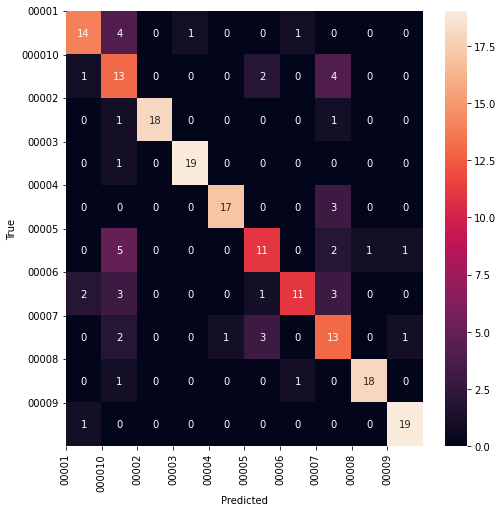

True positive rate:  [0.7  0.65 0.9  0.95 0.85 0.55 0.55 0.65 0.9  0.95]
False positive rate:  [0.02222222 0.09444444 0.         0.00555556 0.00555556 0.03333333
 0.01111111 0.07222222 0.00555556 0.01111111]
OVERALL ACC [0.95  0.88  0.99  0.99  0.98  0.925 0.945 0.9   0.985 0.985]
Precision: 0.43333333333333335
Recall: 0.07386363636363637
F1 Score: 0.12621359223300974


In [65]:

#Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]

accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
    

# Confusion Matrix
cm = confusion_matrix(true_class, predictions)
print(cm)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xticks(np.arange(cm.shape[0]), ['00001','000010','00002','00003','00004','00005','00006','00007','00008','00009'], rotation=90)
plt.yticks(np.arange(cm.shape[0]),['00001','000010','00002','00003','00004','00005','00006','00007','00008','00009'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

    
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN =cm.sum() - (FP +FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)
print("True positive rate: ",TPR)
print("False positive rate: ",FPR)
print("OVERALL ACC", ACC)

precision = float(TP[1]) / (TP[1] + FP[1])
recall = float(TP[1]) / (TP[1] + TN[1])

f1 = 2*precision*recall / (precision + recall)

print ("Precision: " + str(precision))
print("Recall: " + str(recall))
print ("F1 Score: " + str(f1))